In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Đọc dữ liệu
df = pd.read_csv("datasets/du_lieu_diem_thi_2017_2024.csv")

# Đổi tên cột cho dễ làm việc
df.columns = ['nam', 'ma_tinh', 'sbd', 'toan', 'van', 'ly', 'hoa', 'sinh', 'su', 'dia', 'gdcd', 'nn', 'ma_nn', 'tong_diem', 'khoi_a', 'khoi_a1', 'khoi_b', 'khoi_c', 'khoi_d']

# Chuyển các cột điểm về kiểu số
cols_diem = ['toan', 'van', 'ly', 'hoa', 'sinh', 'su', 'dia', 'gdcd', 'nn', 'tong_diem', 'khoi_a', 'khoi_a1', 'khoi_b', 'khoi_c', 'khoi_d']
df[cols_diem] = df[cols_diem].apply(pd.to_numeric, errors = 'coerce')

# Tạo cột tỉnh từ mã tỉnh
ma_tinh = {
    '01': 'Hà Nội', '02': 'TP. Hồ Chí Minh', '03': 'Hải Phòng', '04': 'Đà Nẵng',
    '05': 'Hà Giang', '06': 'Cao Bằng', '07': 'Lai Châu', '08': 'Lào Cai',
    '09': 'Tuyên Quang', '10': 'Lạng Sơn', '11': 'Bắc Kạn', '12': 'Thái Nguyên',
    '13': 'Yên Bái', '14': 'Sơn La', '15': 'Phú Thọ', '16': 'Vĩnh Phúc',
    '17': 'Quảng Ninh', '18': 'Bắc Giang', '19': 'Bắc Ninh', '21': 'Hải Dương',
    '22': 'Hưng Yên', '23': 'Hòa Bình', '24': 'Hà Nam', '25': 'Nam Định',
    '26': 'Thái Bình', '27': 'Ninh Bình', '28': 'Thanh Hóa', '29': 'Nghệ An',
    '30': 'Hà Tĩnh', '31': 'Quảng Bình', '32': 'Quảng Trị', '33': 'Thừa Thiên-Huế',
    '34': 'Quảng Nam', '35': 'Quảng Ngãi', '36': 'Kon Tum', '37': 'Bình Định',
    '38': 'Gia Lai', '39': 'Phú Yên', '40': 'Đắk Lắk', '41': 'Khánh Hòa',
    '42': 'Lâm Đồng', '43': 'Bình Phước', '44': 'Bình Dương', '45': 'Ninh Thuận',
    '46': 'Tây Ninh', '47': 'Bình Thuận', '48': 'Đồng Nai', '49': 'Long An',
    '50': 'Đồng Tháp', '51': 'An Giang', '52': 'Bà Rịa-Vũng Tàu', '53': 'Tiền Giang',
    '54': 'Kiên Giang', '55': 'Cần Thơ', '56': 'Bến Tre', '57': 'Vĩnh Long',
    '58': 'Trà Vinh', '59': 'Sóc Trăng', '60': 'Bạc Liêu', '61': 'Cà Mau',
    '62': 'Điện Biên', '63': 'Đắk Nông', '64': 'Hậu Giang'
}

df['ma_tinh_str'] = df['ma_tinh'].astype(str).str.zfill(2)
df['tinh'] = df['ma_tinh_str'].map(ma_tinh)

In [4]:
print("Số dòng ban đầu:", len(df))

# Loại bỏ dòng không có điểm Toán, Văn, Ngoại ngữ (3 Môn thi bắt buộc nên nếu không có thì khả năng cao là không hợp lệ)
df = df[df[['toan', 'van', 'nn']].notna().all(axis = 1)]
print("Số dòng sau khi loại bỏ dòng không có điểm Toán, Văn, Ngoại ngữ:", len(df))

# Lọc học sinh không có tổng điểm
df = df[df['tong_diem'].notna()]
print(f"Số dòng sau khi lọc học sinh không có tổng điểm: {len(df)}")

# Kiểm tra và loại bỏ dòng trùng lặp
df = df.drop_duplicates()
print(f"Số dòng sau khi loại bỏ dòng trùng lặp: {len(df)}")

Số dòng ban đầu: 7609969
Số dòng sau khi loại bỏ dòng không có điểm Toán, Văn, Ngoại ngữ: 6629910
Số dòng sau khi lọc học sinh không có tổng điểm: 6579989
Số dòng sau khi loại bỏ dòng trùng lặp: 6569125


## Dự đoán điểm toán dựa trên điểm lý và anh bằng các mô hình khác nhau


### Phân tích dữ liệu


<Axes: xlabel='toan', ylabel='Count'>

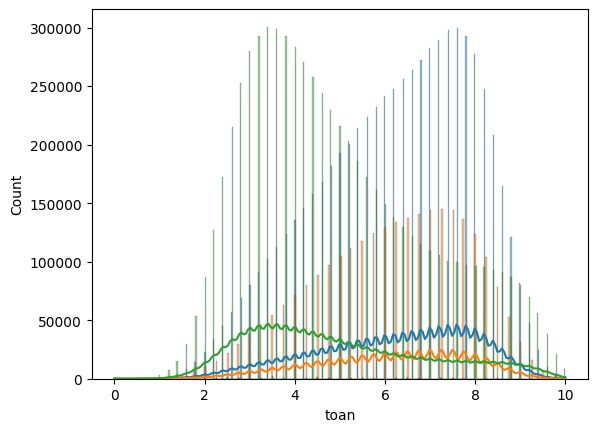

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['toan'], kde=True)
sns.histplot(df['ly'], kde=True)
sns.histplot(df['nn'], kde=True)

<Axes: >

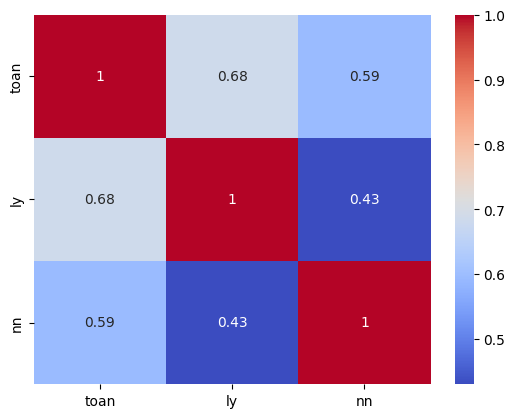

In [8]:
# sns.pairplot(df[['toan', 'ly', 'nn']])
sns.heatmap(df[['toan', 'ly', 'nn']].corr(), annot=True, cmap='coolwarm')

### 1. Chuẩn bị dữ liệu


In [4]:
df_model = df[['toan', 'ly', 'nn']].dropna()
X = df_model[['ly', 'nn']]
y = df_model['toan']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### 2. Linear Regression


In [6]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = root_mean_squared_error(y_test, y_pred_lr)

print("Linear Regression:")
print("Hệ số hồi quy:", lr_model.coef_)
print("Intercept:", lr_model.intercept_)
print(f"R²: {r2_lr:.4f}")
print(f"RMSE: {rmse_lr:.4f}")

Linear Regression:
Hệ số hồi quy: [0.48689316 0.1690862 ]
Intercept: 3.225395665633443
R²: 0.5127
RMSE: 0.9755


### 3. Random Forest Regressor


In [7]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)

print("Random Forest:")
print(f"R²: {r2_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")

Random Forest:
R²: 0.5419
RMSE: 0.9458


### 4. XGBoost


In [8]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = root_mean_squared_error(y_test, y_pred_xgb)

print("XGBoost:")
print(f"R²: {r2_xgb:.4f}")
print(f"RMSE: {rmse_xgb:.4f}")

XGBoost:
R²: 0.5422
RMSE: 0.9455


### 5. KNN Regressor


In [9]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

r2_knn = r2_score(y_test, y_pred_knn)
rmse_knn = root_mean_squared_error(y_test, y_pred_knn)

print("KNN:")
print(f"R²: {r2_knn:.4f}")
print(f"RMSE: {rmse_knn:.4f}")

KNN:
R²: 0.4533
RMSE: 1.0333
